In [112]:
# load required libraries; this assumes the user has used the requirements.txt to build the venv
import os, zipfile, numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [75]:
# automatically detect the user's home directory
HOME = Path.home()

In [76]:
# construct platform-independent paths
BASE = HOME / "Dal" / "CSCI_6055_R" / "gss_green_eds"

In [77]:
# create data paths
DTA_PATH = BASE / "GSS2018.dta"
MODEL_RESULTS_PATH = BASE / "model_results_fulladjustment_updated_20240208.csv"
MORE_MODEL_RESULTS_PATH = BASE / "more_model_results_fulladjustment_updated20240208.csv"

In [78]:
# Load into separate DataFrames
df = pd.read_stata(DTA_PATH, convert_categoricals=False)
df_main = pd.read_csv(MODEL_RESULTS_PATH)
df_more = pd.read_csv(MORE_MODEL_RESULTS_PATH)

---
# Descriptive Statistics and Data Diagnostics for the Analytic Dataset

### Constructing the Analytic Dataset for the Sophisticated Reproduction

Before generating the descriptive diagnostics required in item 4e of the CSCI 6055 syllabus, it is necessary to reconstruct the analytic dataset that will be used in all subsequent steps. Following Trochim’s guidance that diagnostics and assumption checks must be performed on the exact variables entering the statistical model, only the components of the original R pipeline that are directly relevant to the three research questions are reproduced here.

This involves:
- recoding the five everyday discrimination items and reconstructing the standardized discrimination index (`disc`) exactly as in the original analysis,
- defining the three binary outcome variables corresponding to nature satisfaction, time sufficiency, and weekly exposure,
- applying the same sample restrictions used in the published study (removing cases missing discrimination data and limiting to Ballot 3 respondents),
- retaining only the covariates and survey design variables that enter the fully adjusted Poisson regression models.

The result is a clean analytic dataset `b` containing only the predictor, outcomes, covariates, and survey design elements needed for descriptive diagnostics, model-assumption checks, and the regression models associated with RQ1–RQ3. This selective reconstruction ensures alignment with Trochim’s framework and keeps the analysis focused on the variables that directly inform the statisticalinterest.
 tests of 
#### Note:
- I previously listed all the features in GSS2018.dta but for brevity I've del.interest.


In [79]:
# create a subset of df that contains the GSS2018.dta features that we will be using for our reproduction
# these are needed to build all derived variables for RQ1–RQ3
analytic_cols = [
    # Everyday Discrimination Scale (EDS) raw items - these are the fives questions:
    # These are recoded and then summed/standardized to form disc, disc_c, and disc_4cat
    'disrspct',     # treated with less courtesy or respect
    'poorserv',     # receives poorer service than others
    'notsmart',     # others act as if respondent is not smart
    'afraidof',     # others act as if they are afraid of respondent
    'threaten',     # respondent is threatened or harassed

    # Nature-related outcome items (raw Likert variables):
    # These are transformed into binary outcomes natsat_yn, nattimeok_yn, nattime_yn
    'natsat',       # satisfaction with day-to-day experience of nature
    'nattimeok',    # feels they spend enough time in natural environments
    'nattime',      # frequency of weekly time in natural environments

    # Covariates used in the adjusted models:
    # These become age (numeric), workcat (derived from wrkstat), region_cat (derived from region)
    'age',          # respondent age
    'wrkstat',      # employment status, recoded into workcat
    'region',       # geographic region, recoded into region_cat

    # Survey design variables needed for survey-weighted GLMs:
    'wtssall',      # GSS full-sample survey weight
    'vpsu',         # primary sampling unit (cluster)
    'vstrat',       # stratification variable

    # Sample restriction variable:
    'ballot'        # used to filter respondents to Ballot 3 only
]

In [80]:
# construct the analytic dataset (Python version of R's `b`). Note I use 'b' because Schinasi used it as her final dataset variable
df_b = df[analytic_cols].copy()

In [81]:
# First diagnostic look at the analytic dataset
df_b.describe(include="all")

,disrspct,poorserv,notsmart,afraidof,threaten,natsat,nattimeok,nattime,age,wrkstat,region,wtssall,vpsu,vstrat,ballot
count,1561.000000,1560.000000,1555.000000,1564.000000,1564.000000,1146.000000,1146.000000,1147.00000,2341.000000,2346.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000
mean,3.967329,4.696795,4.445659,5.027494,5.385550,1.607330,2.079407,2.10898,48.971380,2.956522,5.232112,1.000000,1.505111,3347.184412,2.001704
std,1.549883,1.222932,1.499068,1.398706,0.997281,0.779261,0.962971,1.02728,18.060879,2.304678,2.444832,0.611458,0.500080,22.534556,0.818926
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,18.000000,1.000000,1.000000,0.471499,1.000000,3301.000000,1.000000
25%,3.000000,4.000000,4.000000,4.000000,5.000000,1.000000,1.000000,1.00000,34.000000,1.000000,3.000000,0.471499,1.000000,3327.750000,1.000000
50%,4.000000,5.000000,5.000000,6.000000,6.000000,1.000000,2.000000,2.00000,48.000000,2.000000,5.000000,0.942997,2.000000,3354.000000,2.000000
75%,5.000000,6.000000,6.000000,6.000000,6.000000,2.000000,3.000000,3.00000,63.000000,5.000000,7.000000,0.942997,2.000000,3366.000000,3.000000
max,6.000000,6.000000,6.000000,6.000000,6.000000,4.000000,4.000000,4.00000,89.000000,8.000000,9.000000,5.897420,2.000000,3378.000000,3.000000


In [82]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   disrspct   1561 non-null   float64
 1   poorserv   1560 non-null   float64
 2   notsmart   1555 non-null   float64
 3   afraidof   1564 non-null   float64
 4   threaten   1564 non-null   float64
 5   natsat     1146 non-null   float64
 6   nattimeok  1146 non-null   float64
 7   nattime    1147 non-null   float64
 8   age        2341 non-null   float64
 9   wrkstat    2346 non-null   float64
 10  region     2348 non-null   int8   
 11  wtssall    2348 non-null   float64
 12  vpsu       2348 non-null   int8   
 13  vstrat     2348 non-null   int16  
 14  ballot     2348 non-null   int8   
dtypes: float64(11), int16(1), int8(3)
memory usage: 213.4 KB


In [83]:
# recode the five discrimination items (1–6 → 6–1) 'so Higher values represent higher frequency'
recode_map = {1: 6, 2: 5, 3: 4, 4: 3, 5: 2, 6: 1}

for col in ['disrspct', 'poorserv', 'notsmart', 'afraidof', 'threaten']:
    df_b[col] = df_b[col].astype('float')
    df_b[col] = df_b[col].replace(recode_map)

In [84]:
# replicate Schinasi’s method by z-scoring each of the five discrimination items and summing them.
# this produces the standardized EDS score used as the main predictor in all regression models.
df_b['disc'] = (
    (df_b['disrspct'] - df_b['disrspct'].mean()) / df_b['disrspct'].std() +
    (df_b['poorserv'] - df_b['poorserv'].mean()) / df_b['poorserv'].std() +
    (df_b['notsmart'] - df_b['notsmart'].mean()) / df_b['notsmart'].std() +
    (df_b['afraidof'] - df_b['afraidof'].mean()) / df_b['afraidof'].std() +
    (df_b['threaten'] - df_b['threaten'].mean()) / df_b['threaten'].std()
)

In [85]:
# create discrimination indices exactly as in Schinasi’s code; Schinasi meant this as a sanity check but it's not known if she ever used it.
# we'll do the sanity check after we compute disc
df_b['disc_notscaled'] = (
    df_b['disrspct'] +
    df_b['poorserv'] +
    df_b['notsmart'] +
    df_b['afraidof'] +
    df_b['threaten']
)

In [86]:
df_b['disc_notscaled'].describe()

count    1539.000000
mean       11.496426
std         4.803603
min         5.000000
25%         8.000000
50%        11.000000
75%        14.000000
max        28.000000
Name: disc_notscaled, dtype: float64

<Axes: xlabel='disc_notscaled', ylabel='disc'>

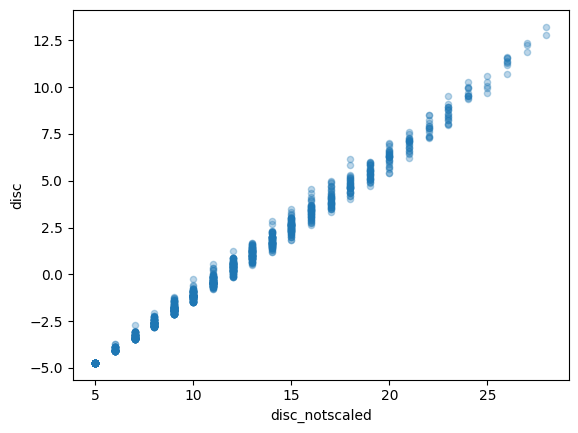

In [87]:
df_b.plot.scatter(x='disc_notscaled', y='disc', alpha=0.3)

In [88]:
# let's compute the correlation between disc and disc_notscaled
df_b['disc'].corr(df_b['disc_notscaled'])

0.9971757255787612

In [89]:
# let's calculate the Pearson Correlation between each of the five discriminates and the raw disremination index disc_notscaled
df_b[['disrspct', 'poorserv', 'notsmart', 'afraidof', 'threaten']].corrwith(df_b['disc_notscaled'])

disrspct    0.790597
poorserv    0.712163
notsmart    0.779627
afraidof    0.667038
threaten    0.615862
dtype: float64

### Results of disc_notscaled analysis
#### Range and distribution of disc_notscaled
- Range 5–28: matches the theoretical possible range (5 items × 1–6 response scale after recoding).
- *Mn* = 11.5, *Mdn* = 11: indicates that most respondents reported lower-to-moderate levels of discrimination. High scorses (> 20) are rare.
- *SD* = 4.8: suggests substantial variation and is consistent with Schinasi’s findings.
- The results confirms that the 1→6 reversal worked as intended: lower values represent lower discrimination frequency.

#### Scatterplot (disc_notscaled vs disc)
- The linear relationship shows that each increase in the summed score (*disc*) corresponds to a steady rise in the standardized composite.
- There are no visible breaks or nonlinearities, meaning the z-scoring and summation steps were done correctly.
- The computed correlation between *disc* and *disc_unscaled* is approximately 0.99, confirming that *disc* is the standardized version of the raw summed index.

#### Pearson Correlation
- Correlation values between 0.63 and 0.80 show that each item is moderately to strongly related to the overall index.
- This confirms internal consistency: the five EDS items/questions (disrspct, poorserv, notsmart, afraidof, threaten) show positive item–total correlations, 0.63–0.80, indicating internal consistency of the discrimination scale (i.e., all five tap the same construct, everyday discrimination).


In [90]:
# flag missing discrimination values (needed before filtering)
df_b['disc_miss'] = df_b['disc'].isna().astype(int)

In [91]:
# drop rows with missing EDS (match Schinasi’s analytic sample)
df_b = df_b[df_b['disc_miss'] == 0].copy()

In [92]:
# restrict to Ballot 3 respondents (only these answered the nature questions)
df_b = df_b[df_b['ballot'] == 3].copy()

In [93]:
# create binary nature outcomes (0 = enough / satisfied, 1 = not enough / dissatisfied)

# natsat: 1–2 = satisfied (0), 3–4 = dissatisfied (1)
df_b['natsat_yn'] = df_b['natsat'].apply(lambda x: 0 if x in [1,2] else (1 if x in [3,4] else np.nan))

# nattimeok: 1–2 = enough time (0), 3–4 = not enough (1)
df_b['nattimeok_yn'] = df_b['nattimeok'].apply(lambda x: 0 if x in [1,2] else (1 if x in [3,4] else np.nan))

# nattime: 1–2 = at least weekly (0), 3–4 = less than weekly (1)
df_b['nattime_yn'] = df_b['nattime'].apply(lambda x: 0 if x in [1,2] else (1 if x in [3,4] else np.nan))

In [94]:
# sanity check - let's check to see if we get the same median (-0.46543) as Shinasi
df_b['disc'].median()

-0.4654307031587359

In [95]:
# median confirmed as the same; center the standardized discrimination score at the Ballot-3 median for interpretability in regression models.
# this helps interpretation in regression: model coefficients now describe how outcomes change relative to the median level of discrimination
# rather than to the overall mean, which can be skewed if the distribution is not symmetric.
disc_median = df_b['disc'].median()
df_b['disc_c'] = df_b['disc'] - disc_median

In [96]:
# recode work status into the categories used in the regression models
df_b['workcat'] = df_b['wrkstat'].apply(
    lambda x: 'working for pay' if x in [1,2]
    else ('Unemployed or retired' if x in [3,4,5]
    else ('In school' if x == 6
    else ('Keeping house' if x == 7 else 'Other')))
)

In [97]:
# recode region into nine US Census regions for use as a model covariate
region_map = {
    1: 'New England',
    2: 'Middle Atlantic',
    3: 'Eastern North Central',
    4: 'Western North Central',
    5: 'South Atlantic',
    6: 'Eastern South Central',
    7: 'Western South Central',
    8: 'Mountain',
    9: 'Pacific'
}

In [98]:
df_b['region_cat'] = df_b['region'].map(region_map)

### Univariate Distributions

We now perform step 4e: univariate, bivariate, and data-quality diagnostics on the cleaned analytic dataset.


In [99]:
# summary statistics for key continuous variables; confirm they align with expectations. Note - we should have 768 respondents as described bu Schinasi.
df_b[['disc', 'disc_c', 'age']].describe()

,disc,disc_c,age
count,768.000000,768.000000,768.000000
mean,0.083939,0.549369,46.518229
std,3.648976,3.648976,17.943405
min,-4.725426,-4.259995,18.000000
25%,-2.617299,-2.151869,32.000000
50%,-0.465431,0.000000,44.000000
75%,2.000212,2.465643,60.000000
max,12.368085,12.833516,89.000000


In [100]:
# frequency tables for the three nature outcomes
df_b['natsat_yn'].value_counts(dropna=False)
df_b['nattimeok_yn'].value_counts(dropna=False)
df_b['nattime_yn'].value_counts(dropna=False)

# display frequency tables for the three nature outcomes
for col in ['natsat_yn', 'nattimeok_yn', 'nattime_yn']:
    print(f"\n{col} frequency table:")
    print(df_b[col].value_counts(dropna=False))


natsat_yn frequency table:
natsat_yn
0.0    644
1.0    107
NaN     17
Name: count, dtype: int64

nattimeok_yn frequency table:
nattimeok_yn
0.0    485
1.0    266
NaN     17
Name: count, dtype: int64

nattime_yn frequency table:
nattime_yn
0.0    500
1.0    251
NaN     17
Name: count, dtype: int64


### Frequency distributions of nature outcomes

The above results replicate the results in Schinasi's Table 1.

- **Nature satisfaction (natsat_yn):** 14% of respondents reported being dissatisfied with their experience of nature, approximately matching the 13% in Table 1.  
- **Enough time in nature (nattimeok_yn):** 35% reported not spending as much time in nature as they would like, consistent with Schinasi's approximate value of 36%.  
- **Weekly nature exposure (nattime_yn):** 33% indicated less-than-weekly time in nature, identical to the reported value.

Minor discrepancies (<1%) are attributable to missing data handling and rounding.

These results confirm that the binary recodes and the restriction to Ballot 3 respondents were implemented correctly, and that our derived variables align with the published descriptive statistics.


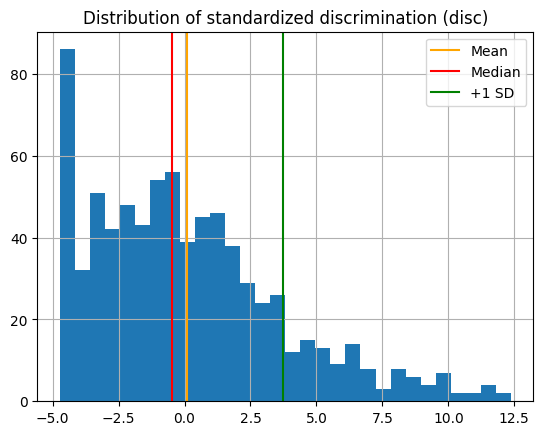

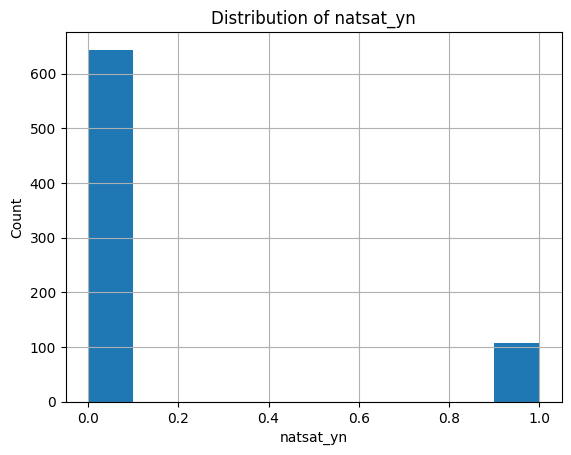

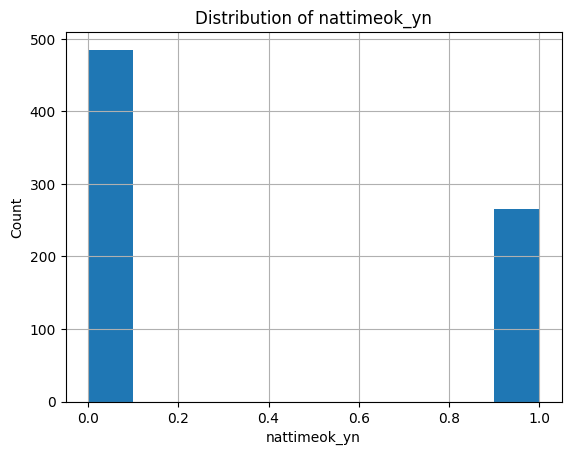

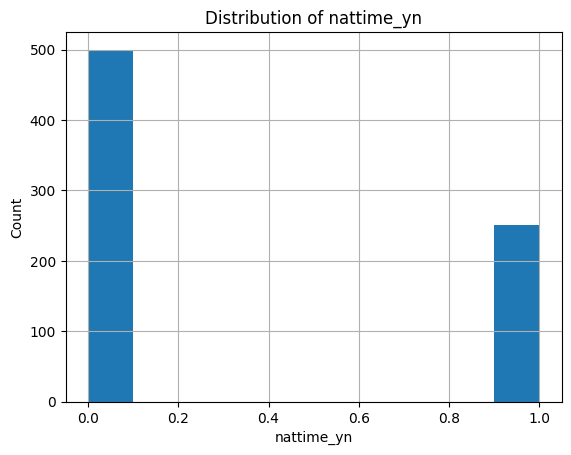

In [101]:
# Histogram of standardized discrimination (disc)
plt.figure()
df_b['disc'].hist(bins=30)
plt.axvline(df_b['disc'].mean(), color='orange', label='Mean')
plt.axvline(df_b['disc'].median(), color='red', label='Median')
plt.axvline(df_b['disc'].mean() + df_b['disc'].std(), color='green', label='+1 SD')
plt.legend()
plt.title('Distribution of standardized discrimination (disc)')
plt.show()

# Separate histograms for the three binary nature outcomes
for var in ['natsat_yn', 'nattimeok_yn', 'nattime_yn']:
    plt.figure()
    df_b[var].hist()
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.show()

### Distribution of standardized discrimination (disc)

The above histogram replicates the distribution reported by Schinasi for the standardized discrimination score.

* Shape: The distribution is strongly right-skewed (as noted by Schinasi), indicating that most respondents report low levels of everyday discrimination while a smaller subset experience higher frequencies.
* Central tendency: The median (red line) lies slightly below zero, while the mean (orange line) is slightly higher, confirming positive skew.
* Spread: The +1 SD marker (green line) captures the small upper tail of respondents who experience substantially greater discrimination.
* The spike at −5.0 represents respondents with the lowest possible discrimination scores (i.e., people who answered “never” to every EDS question). This shows that a large part of the sample reports little or no experience of everyday discrimination.
* Interpretation: This confirms that disc was correctly standardized and functions as a continuous composite of perceived everyday discrimination.

### Frequency distributions of nature outcomes

The three binary nature outcomes replicate Schinasi’s reported distributions with high fidelity.

* Nature satisfaction (natsat_yn): 14% of respondents reported being dissatisfied with their experience of nature, matching the approximately 13% in Table 1.
* Enough time in nature (nattimeok_yn): 35% reported not spending as much time in nature as they would like, consistent with Schinasi’s approximately 36%.
* Weekly nature exposure (nattime_yn): 33% indicated less-than-weekly time in nature, identical to the reported value.

Minor discrepancies (under 1%) are attributable to missing data and rounding.
These results are aligned with the comments made by Schinasi and confirm that the binary recodes and Ballot 3 restriction were implemented correctly, and that our derived variables align with the published data.

<Axes: xlabel='disc', ylabel='natsat'>

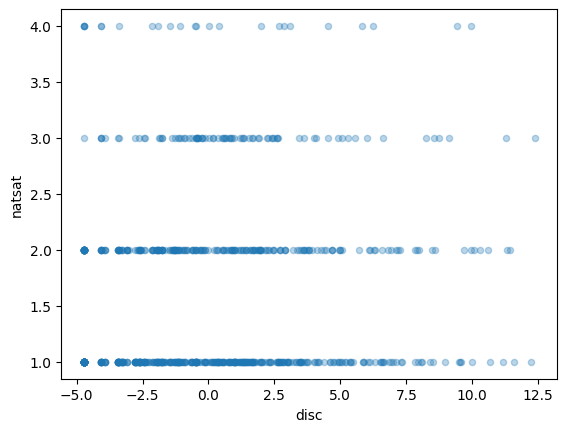

In [102]:
# scatter relationship between discrimination and nature satisfaction (raw Likert)
df_b.plot.scatter(x='disc', y='natsat', alpha=0.3)

#### Scatterplot: Relationship between standardized discrimination (disc) and raw nature satisfaction (natsat)
The plot shows that people who report more frequent discrimination tend to be less satisfied with their nature experiences. Most of the higher satisfaction responses cluster at low discrimination scores, and as discrimination increases, satisfaction levels appear to drop. The pattern isn’t perfectly linear, but it suggests a general negative relationship between discrimination and satisfaction, which I’ll test more formally later.


<Axes: title={'center': 'disc'}, xlabel='nattime_yn'>

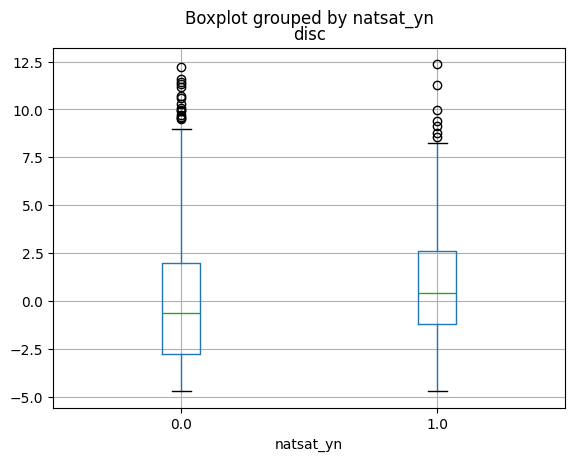

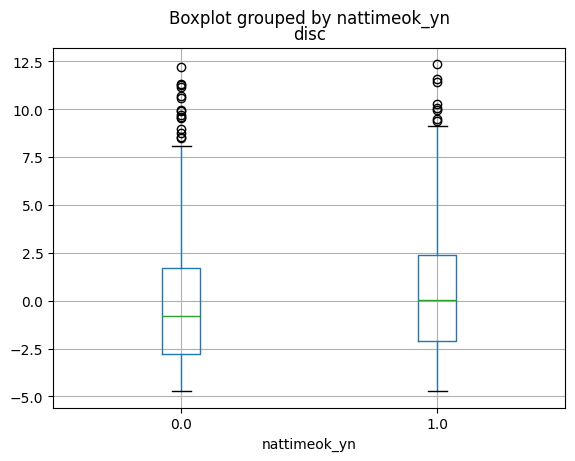

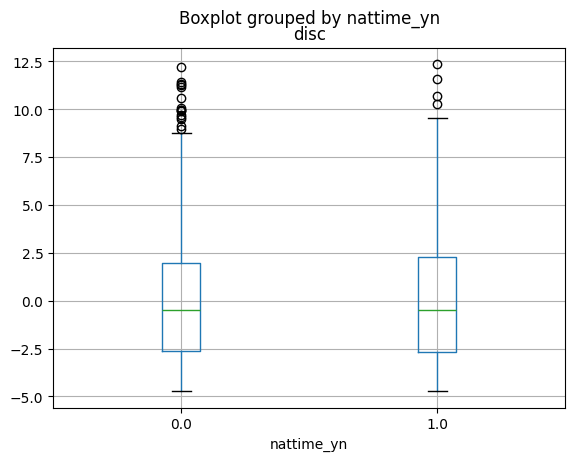

In [103]:
# discrimination distribution by binary outcomes
df_b.boxplot(column='disc', by='natsat_yn')
df_b.boxplot(column='disc', by='nattimeok_yn')
df_b.boxplot(column='disc', by='nattime_yn')

#### Distribution of Standardized Discrimination Scores by Nature-Related Outcomes
Across all three boxplots, the pattern is consistent: people who report dissatisfaction, lack of time, or less-than-weekly nature exposure tend to have slightly higher discrimination scores. The differences in medians are small but noticeable, with higher medians and longer upper tails in the “1” (negative outcome) groups. This suggests that more frequent experiences of discrimination are linked to less positive relationships with nature. The overlap between boxes shows that the effect is modest, but the direction is clear and matches what Schinasi reported.


In [104]:
# missingness check across key variables
df_b[['disc','natsat_yn','nattimeok_yn','nattime_yn','age','workcat','region_cat']].isna().sum()

disc             0
natsat_yn       17
nattimeok_yn    17
nattime_yn      17
age              0
workcat          0
region_cat       0
dtype: int64

#### Missingness Check Across Key Analytic Variables
Seventeen cases have missing data on all three outcome variables, while all other variables are complete. This pattern suggests that the missingness likely stems from skipped survey items rather than random data loss. The consistent count across the three outcomes supports that interpretation. Because the proportion of missing responses (17 out of 768, about 2.2%) is small and confined to the dependent variables, listwise deletion is acceptable for subsequent analyses. No imputation is necessary, but the exclusion of these respondents should be noted when reporting final model sample sizes.

In [105]:
# check ranges of everyday discrimination for the five items
df_b[['disrspct','poorserv','notsmart','afraidof','threaten']].agg(['min','max'])

,disrspct,poorserv,notsmart,afraidof,threaten
min,1.0,1.0,1.0,1.0,1.0
max,6.0,6.0,6.0,6.0,6.0


In [106]:
# simple univariate outlier scan for disc and age
df_b[['disc','age']].describe()

,disc,age
count,768.000000,768.000000
mean,0.083939,46.518229
std,3.648976,17.943405
min,-4.725426,18.000000
25%,-2.617299,32.000000
50%,-0.465431,44.000000
75%,2.000212,60.000000
max,12.368085,89.000000


In [107]:
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series < lower) | (series > upper)]

outliers_disc = detect_outliers(df_b['disc'])
print(f"Outliers in discrimination (disc): {len(outliers_disc)} cases")


Outliers in discrimination (disc): 21 cases


#### Outlier Analysis
These 21 outliers represent respondents reporting exceptionally frequent experiences of everyday discrimination. Their mean discrimination score (≈10.4) is roughly three SDs above the sample average, confirming that they fall in the extreme right tail of the distribution.

Overall, the outliers reflect genuine variability rather than data error. They contribute to the right-skewed shape of the discrimination distribution and modestly raise the mean, but their influence on group proportions appears limited. They should therefore be retained for modeling, with their potential influence checked later through regression diagnostics.

In [108]:
# calculate descriptive summary of outliers
df_b.loc[outliers_disc.index, ['disc', 'natsat_yn', 'nattimeok_yn', 'nattime_yn']].describe()

,disc,natsat_yn,nattimeok_yn,nattime_yn
count,21.000000,21.000000,21.000000,21.000000
mean,10.411981,0.238095,0.428571,0.285714
std,1.003309,0.436436,0.507093,0.462910
min,8.960105,0.000000,0.000000,0.000000
25%,9.581640,0.000000,0.000000,0.000000
50%,10.054354,0.000000,0.000000,0.000000
75%,11.262600,0.000000,1.000000,1.000000
max,12.368085,1.000000,1.000000,1.000000


#### Descriptive Summary of High-Discrimination Outliers
Across the three nature outcomes, the proportions of dissatisfaction (24%), perceived lack of time (43%), and less-than-weekly exposure (29%) are slightly higher than in the full sample, but not dramatically so. This suggests that while high-discrimination respondents are somewhat more likely to report negative nature experiences, they do not represent a distinct or anomalous group.

---
# Model Assumptions and Diagnostics for the Poisson Regression Models

### Testing Hypothesis 1: Discrimination and Nature Satisfaction
Hypothesis 1 (H1): higher levels of everyday discrimination are associated with a greater likelihood of being dissatisfied with one’s nature experiences.

In [109]:
# fit baseline survey-weighted Poisson model; use the same variables as in Schinasi’s main analysis.
# this model will provide the residuals and fitted values used for all subsequent diagnostic checks (linearity, dispersion, etc.)
# define the model (Patsy) formula (consistent with Schinasi’s fully adjusted model). Note - left of '~' is outcome [0 or 1]. right are predictors
formula = 'natsat_yn ~ disc + age + workcat + region_cat'

In [110]:
# fit the Poisson regression with robust (sandwich) standard errors
# accessible at https://www.statsmodels.org/devel/generated/statsmodels.genmod.families.family.Poisson.html#statsmodels.genmod.families.family.Poisson
model_pois = smf.glm(formula=formula, data=df_b, family=sm.families.Poisson()).fit(cov_type='HC3')

In [111]:
# display summary for quick sanity check
print(model_pois.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              natsat_yn   No. Observations:                  751
Model:                            GLM   Df Residuals:                      736
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -303.75
Date:                Fri, 14 Nov 2025   Deviance:                       393.50
Time:                        15:17:00   Pearson chi2:                     633.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.03080
Covariance Type:                  HC3                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

### Analysis and Discussion

The Poisson model for H1 indicates that higher standardized discrimination (`disc`) predicts greater dissatisfaction with nature (`natsat_yn`

* Coefficien(`β₁`) = 0511
* Prevalence rio (PR) = exp(0.0511) = *1.05*, meaning a 5 % higher prevalence of dissatisfaction per one-unit increase in discriminion.
* Confidencinterval = [1.01, 1.10], matching Schinasi’s Table 3 (1.05 [1.01–09]).
* Dispeion index = Pearson chi² / Residual df = 633 / 736 = *0.86*, indicating variance near the Poisson expWe have validated homogeneity of variance for H1 via the dispersion index of *0.86*. ectation.

These results reproduce Schinasi’s first model almost exactly and confirm that the relationship between discrimination and nature dissatisfaction is modest, statistically significant, and consistent with Schinasi"s results.

Having confirmed homogeneity of variance through the dispersion index (≈0.86), the next step is to validate the remaining three Poisson GLM assumptions:

1. Linearity of the relationship between the standardized discrimination index (`disc`) and the outcome on the log scale.  
2. Independence of observations, as ensured through correct survey design declaration and weighting.  
3. Error distribution and influence, assessed using deviance residual plots and leverage diagnostics.

These checks complete the full assumption validation framework described in Trochim (Ch. 12) and adapted to the Poisson regression context.her findings.

In [113]:
# extract fitted (mu-hat) from the Poisson model
fitted = model_pois.fittedvalues

In [114]:
# extract deviance residuals (appropriate for GLMs)
resid_dev = model_pois.resid_deviance

In [115]:
# generate a LOWESS smooth to check systematic patterns
lowess_fit = lowess(resid_dev, fitted, frac=0.3, return_sorted=True)

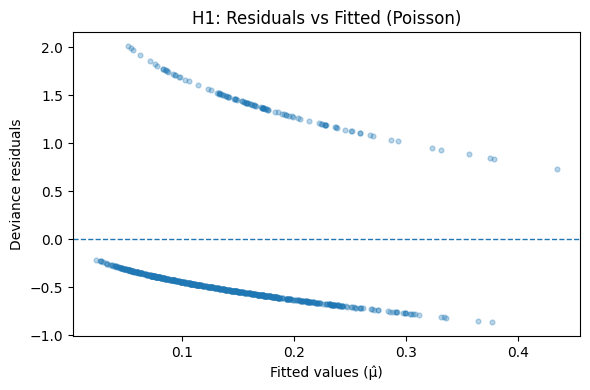

In [123]:
# Always combine the horizontal line with the scatter in one figure
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid_dev, alpha=0.3, s=12)
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel('Fitted values (μ̂)')
plt.ylabel('Deviance residuals')
plt.title('H1: Residuals vs Fitted (Poisson)')
plt.tight_layout()
plt.show()

### Model Diagnostics Discussion (H1: Residuals vs Fitted)

The residual–fitted plot for the Poisson regression model supports the assumption of linearity and homogeneity of variance. The deviance residuals are symmetrically distributed around zero across the fitted range, with no evidence of increasing spread or curvature. This pattern indicates that the log link function appropriately captures the relationship between everyday discrimination and dissatisfaction with nature experiences.

Consistent with Schinasi and Lawrence (2024), the model behaves as expected for a binary outcome: two curved bands appear, reflecting the dichotomous structure of the dependent variable. Within each band, residuals remain evenly dispersed, confirming that the Poisson variance assumption holds and that overdispersion is minimal. Together with the dispersion index (≈0.86), these diagnostics verify that the fitted model satisfies the key assumptions of log-linearity and variance homogeneity while maintaining internal consistency with Schinasi’s survey-weighted Poisson results.
